**Imports and workspace setting**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
plt.style.use('ggplot')

**Loading data file**

In [3]:
cancerData = pd.read_csv('../data/breast-cancer-wisconsin.data', header=None)
cancerData.drop(cancerData.columns[0],axis=1,inplace=True)
cancerData = cancerData.replace('?', np.nan)
cancerData.head()

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


**Stats of the data**

In [4]:
cancerData.shape

(699, 10)

**Class distribution of benign (2) and malignant (4)**

Class distribution is skewed towards benign.

Text(0.5, 0, 'Class')

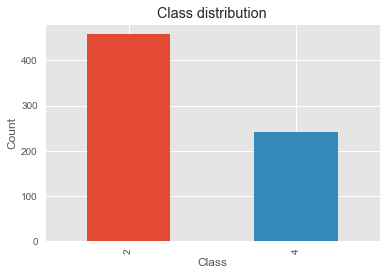

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
axes = cancerData[10].value_counts().plot(kind='bar', title='Class distribution')
axes.set_ylabel('Count')
axes.set_xlabel('Class')

**Drop missing values (16 values with ? mark)**

In [6]:
cancerDataAfterMissingValuesDropped = cancerData.dropna()
cancerDataAfterMissingValuesDropped.shape

(683, 10)

In [7]:
y = cancerDataAfterMissingValuesDropped.values[:,-1]
y=y.astype('int')
y.shape

(683,)

In [8]:
X = cancerDataAfterMissingValuesDropped.values[:,:-1]
X=X.astype('int')
X.shape

(683, 9)

**Holdout to create training (65%) and testing (35%) dataset**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=8)
print (str(X_train.shape) +","+ str(y_train.shape))
print (str(X_test.shape) +","+ str(y_test.shape))

(443, 9),(443,)
(240, 9),(240,)


**Hyper paramter tuning for Random Forest - RandomizedSearchCV to first localize parameter values**

In [15]:
random_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.1min finished


{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [17]:
predictions = rf_random.best_estimator_.predict(X_test)
score = rf_random.best_estimator_.score(X_test, y_test)
print('Accuracy score = ', score)

Accuracy score =  0.975


**GridSearchCV around those values to optimize parameters further - narrow search**

In [19]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1400, 1600, 1800, 2000]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 20.1min finished


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 1800}

**Fit Random forest model**

In [20]:
randomForest = RandomForestClassifier(**grid_search.best_params_, random_state=0)
randomForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [21]:
predictions = randomForest.predict(X_test)

In [22]:
score = randomForest.score(X_test, y_test)
print('Accuracy score = ', score)

Accuracy score =  0.9833333333333333


**Classification report**

In [24]:
target_names = ['2 (benign)', '4 (malignant)']
print(metrics.classification_report(y_test,predictions, target_names=target_names, digits=3))

               precision    recall  f1-score   support

   2 (benign)      0.986     0.986     0.986       147
4 (malignant)      0.978     0.978     0.978        93

    micro avg      0.983     0.983     0.983       240
    macro avg      0.982     0.982     0.982       240
 weighted avg      0.983     0.983     0.983       240



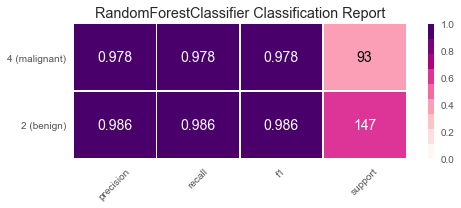

In [25]:
fig, ax = plt.subplots(figsize=(7,3))
visualizer = ClassificationReport(randomForest, classes=target_names, support=True, cmap='RdPu')
visualizer.score(X_test, y_test)
for label in visualizer.ax.texts:
    label.set_size(14)
g = visualizer.poof()

**Confusion metrix**

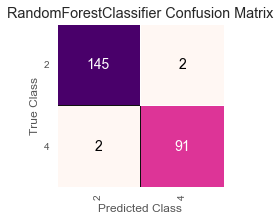

In [26]:
fig, ax = plt.subplots(figsize=(3,3))
cm = ConfusionMatrix(randomForest, classes=[2,4], cmap='RdPu')
cm.score(X_test, y_test)
for label in cm.ax.texts:
    label.set_size(14)
cm.poof()

**Conclusion**
01. Model works really well and provides an impressive 98.3% accuracy after hyper parameter tuning was included. Before hyper parameter tuning, only 97.5% was achieved which is also better than all classifiers tested so far.
02. Skewed class problem is still seen clearly with random foress classifier as well. All measures of malignant class were less than the benign class. Random forest does not have a method to weight the class distribution like in LogisticRegression.